
# prediccion de incidentes viales en la ciudad de Medellin

## importacion librerias necesarias

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


## lectura y exploracion de los datos

In [3]:
#lectura dataframe saltando las filas malas
df=pd.read_csv("incidentes_viales.csv",on_bad_lines='skip',index_col=False,sep=";",encoding="UTF-8")
print(df.head())

    AÑO  CBML CLASE_ACCIDENTE      DIRECCION       DIRECCION ENCASILLADA  \
0  2015  1013  Caida Ocupante    CR 46 CL 43    CR  046   043  000 00000   
1  2015  1020          Choque  CR 43 A CL 29  CR  043 A   029  000 00000   
2  2015  0205            Otro    CR 46 CL 37    CR  046   037  000 00000   
3  2015  0101       Atropello   CR 34 CL 112    CR  034   112  000 00000   
4  2015  1504          Choque    CR 50 CL 14    CR  050   014  000 00000   

         DISEÑO  EXPEDIENTE      FECHA_ACCIDENTE          FECHA_ACCIDENTES  \
0  Tramo de via  A000259731  21/10/2015 05:58:00  2015-10-21T10:58:00.000Z   
1  Tramo de via  A000261725  05/11/2015 03:00:00  2015-11-05T08:00:00.000Z   
2  Tramo de via  A000259739  21/10/2015 07:40:00  2015-10-21T12:40:00.000Z   
3  Tramo de via  A000259752  21/10/2015 12:00:00  2015-10-21T17:00:00.000Z   
4  Tramo de via  A000259949  03/11/2015 06:16:00  2015-11-03T11:16:00.000Z   

  GRAVEDAD_ACCIDENTE  MES NRO_RADICADO NUMCOMUNA                     BARRI

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (0,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#revisamos las columnas
print(df.columns)
print("numero de columnas iniciales ",len(df.columns))
print("numero de filas iniciales ",df.shape[0])


Index(['AÑO', 'CBML', 'CLASE_ACCIDENTE', 'DIRECCION', 'DIRECCION ENCASILLADA',
       'DISEÑO', 'EXPEDIENTE', 'FECHA_ACCIDENTE', 'FECHA_ACCIDENTES',
       'GRAVEDAD_ACCIDENTE', 'MES', 'NRO_RADICADO', 'NUMCOMUNA', 'BARRIO',
       'COMUNA', 'LOCATION', 'X', 'Y'],
      dtype='object')
numero de columnas iniciales  18
numero de filas iniciales  270765


## limpieza de datos

In [5]:
#eliminacion de datos con nulos
df.dropna(inplace=True)
#eliminar datos duplicados
df.drop_duplicates(inplace=True)
print(df.shape[0])

250686


In [6]:
#AÑO-Año de ocurrencia del incidente
df["AÑO"]=df["AÑO"].apply(lambda x : re.findall(r"[0-9]{4}",str(x))[0])
print(df["AÑO"].unique())

['2015' '2014' '2016' '2017' '2018' '2019' '2020']


In [7]:
#CBML-Codigo catastral que corresponde al codigo comuna, barrio, manzana, lote catastral de un predio.
print(len(df["CBML"].unique()))

521


In [8]:
#CLASE_ACCIDENTE-Clasificación del IPAT sobre la clase de accidente de transito: choque, atropello, volcamiento,
#caida de ocupante, incendio, u otro (que no corresponde a las anteriores 5 clasificaciones, p. ej: sumersión)
df["CLASE_ACCIDENTE"]=df["CLASE_ACCIDENTE"].apply(lambda x : str(x).replace("Caída de Ocupante","Caida Ocupante").lower())
print((df["CLASE_ACCIDENTE"].unique()))

['caida ocupante' 'choque' 'otro' 'atropello' 'volcamiento' 'incendio']


In [9]:
#DIRECCION-Dirección donde ocurrió el incidente
##aparentemente se encuentra ya formateada
print((df["DIRECCION"].sample(10)))

223383       CL 14 CR 48
2659       CL 75 CR 49 A
47220       CR 74 CL 110
44505     DG 75 B CL 2 A
58320        CR 51 CL 67
210440     CR 51 D CL 59
260932       CL 10 CR 52
74591      CR 63 A CL 45
155091       CL 49 CR 24
267914     CR 43 A CL 16
Name: DIRECCION, dtype: object


In [10]:
#DIRECCION ENCASILLADA-	Dirección encasillada que entrega el geocodificador
##aparentemente se encuentra ya formateada
##variable con poca informacion util dada la variable anterior--escoger una de las 2
print((df["DIRECCION ENCASILLADA"].sample(10)))

67916      CL S 004   025  000 00000
228607      CR  052   009  000 00000
203554    CL  084   067 A  000 00000
140688      CL  080   088  000 00000
88152       CR  086   035  000 00000
27655     CR  073   047 D  000 00000
35745       CR  062   050  000 00000
52055       CR  050   014  000 00000
122525      CR  045   072  000 00000
108787    CR  040   066 C  000 00000
Name: DIRECCION ENCASILLADA, dtype: object


In [11]:
#DISENO-Sitio de la vía donde ocurrió el accidente: Cicloruta, Glorieta, Interseccion, Lote o Predio, Paso a Nivel, Paso Elevado,
#Paso Inferior, Pontón, Puente, Tramo de via, Tunel, Via peatonal
df["DISEÑO"]=df["DISEÑO"].apply(lambda x : str(x).replace("Pont\\xF3n","Pontón").lower())
print((df["DISEÑO"].unique()))

['tramo de via' 'interseccion' 'glorieta' 'lote o predio' 'paso a nivel'
 'puente' 'paso elevado' 'ciclo ruta' 'paso inferior' 'via peatonal'
 'pontón' 'tunel']


In [12]:
#EXPEDIENTE
#Consecutivo que asigna UNE, según el orden de llegada de los expedientes para su diligenciamiento
##variable  aprarentemente con poco valor
print((df["EXPEDIENTE"].sample(10)))

176605    A001152709
146602    A000493725
128597    A000589313
14963     A000488381
118373    A000181094
180520    A000768359
182869    A000847680
86277     A000300765
10719     A000667867
13483     A000481493
Name: EXPEDIENTE, dtype: object


In [13]:
#FECHA_ACCIDENTE
#Fecha del accidente, proviene del IPAT - Informe Policial de accidente de Tránsito
df["FECHA_ACCIDENTE"] = pd.to_datetime(df["FECHA_ACCIDENTE"],dayfirst=True)
print((df["FECHA_ACCIDENTE"].sample(10)))

164451   2019-06-06 19:40:00
197445   2014-11-05 10:45:00
91053    2015-08-25 10:20:00
66588    2020-03-09 17:30:00
252568   2019-04-05 06:50:00
248677   2018-06-16 21:15:00
154857   2018-02-16 17:15:00
139456   2018-12-24 19:30:00
114960   2016-04-23 07:00:00
157540   2018-12-18 17:50:00
Name: FECHA_ACCIDENTE, dtype: datetime64[ns]


In [14]:
#FECHA_ACCIDENTES
#Fecha de los accidente (formato YYYY-MM-DD hh:mi:ss), proviene del IPAT - Informe Policial de accidentes de Tránsito
##veriable redundante con la anterior
print((df["FECHA_ACCIDENTES"].head(10)))

0    2015-10-21T10:58:00.000Z
1    2015-11-05T08:00:00.000Z
2    2015-10-21T12:40:00.000Z
3    2015-10-21T17:00:00.000Z
4    2015-11-03T11:16:00.000Z
5    2015-11-05T09:30:00.000Z
6    2015-10-18T09:40:00.000Z
7    2015-11-04T09:46:00.000Z
8    2015-10-21T12:00:00.000Z
9    2015-11-05T12:00:00.000Z
Name: FECHA_ACCIDENTES, dtype: object


In [15]:
#GRAVEDAD_ACCIDENTE
#Clasificación del IPAT - Informe Policial de Accidentes de Tránsito, sobre la gravedad del accidente, corresponde al resultado 
#más grave presentado en el accidente. Daños materiales "Sólo daños", accidente con heridos "Herido", accidente con muertos 
#"Muerto". No indica cantidad
df["GRAVEDAD_ACCIDENTE"]=df["GRAVEDAD_ACCIDENTE"].apply(lambda x : str(x).replace("Solo da\\xF1os","Solo daños").lower())
print((df["GRAVEDAD_ACCIDENTE"].unique()))

['con heridos' 'solo daños' 'con muertos']


In [16]:
#MES
#Mes de ocurrencia del incidente vial
print((df["MES"].unique()))

[10 11 12  9  4  3  5  6  7  8  1  2]


In [17]:
#NRO_RADICADO
#Consecutivo que asigna UNE, según el orden de llegada de los expedientes para su diligenciamiento
#no tiene mucho valor aparentemente para nuestros fines
print((df["NRO_RADICADO"].head()))

0    1508668
1    1510621
2    1508691
3    1508694
4    1510634
Name: NRO_RADICADO, dtype: object


In [18]:
#NUMCOMUNA
#Numero de la comununa en la que ocurrio incidente vial
#se eliminan las filas con valores que no corespondan con 
df=df[df["NUMCOMUNA"]!="AU"]
df=df[df["NUMCOMUNA"]!="Sin Inf"]
df=df[df["NUMCOMUNA"]!="In"]
df=df[df["NUMCOMUNA"]!="SN"]
df=df[df["NUMCOMUNA"]!="0"]
#asuminos que las comunas 60,70,80,90 son las comunas 6,7,8,9 respectivamente
df["NUMCOMUNA"]=df["NUMCOMUNA"].apply(lambda x : (int(x)))
df["NUMCOMUNA"]=df["NUMCOMUNA"].apply(lambda x : x/10 if x >20 else x)
df["NUMCOMUNA"]=df["NUMCOMUNA"].apply(lambda x : str(int(x)))
print(sorted(df["NUMCOMUNA"].unique()))

['1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '7', '8', '9']


In [19]:
#BARRIO
print(len(df["BARRIO"].unique()))
#Barrio de ocurrencia del incidente vial
#ó por o
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).lower().replace("\\xf3","o").replace("ó","o"))
#é por e 
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xe9","e").replace("é","e"))
#á por a 
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xc1","a").replace("\\xe1","a").replace("á","a"))
#ñ
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xf1","ñ"))
#\\xed í por i
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xed","i").replace("í","i"))
#\\xfa ú por u
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xfa","u").replace("ú","u"))
print((df["BARRIO"].unique()))

488
['barrio colon' 'san diego' 'la francia' 'santo domingo savio no. 1'
 'santa fe' 'la florida' 'los conquistadores' 'la alpujarra' 'villa nueva'
 'facultad de minas u. nacional' 'la esperanza' 'perpetuo socorro'
 'campo valdes no. 1' 'miraflores' 'oleoducto' 'terminal de transporte'
 'gerona' 'u.d. atanasio girardot' 'alejandro echavarria'
 'cabecera san antonio de prado' 'manila' 'los balsos no.2' 'moravia'
 'tenche' 'universidad nacional' 'los colores' 'caribe'
 'juan xxiii la quiebra' 'belalcazar' 'santa cruz' 'sucre' 'la candelaria'
 'el estadio' 'suramericana' 'la gloria' 'centro administrativo'
 'las estancias' 'aures no. 2' 'los angeles' 'castilla' 'la salle'
 'la america' 'picacho' 'bosques de san pablo' 'la aguacatala'
 'playon de los comuneros' 'estacion villa' 'la colina' 'popular'
 'villa del socorro' 'cucaracho' 'santa maria de los angeles'
 'el chagualo' 'la mansion' 'san benito' 'la castellana' 'jesus nazareno'
 'loreto' 'asomadera no. 1' 'el salvador' 'cristo rey' 'm

In [20]:
#COMUNA
#Denominación con la cual se identifica cada Comuna o Corregimiento. 01:Popular 02:Santa Cruz 03:Manrique 04:Aranjuez 05:Castilla 06:Doce de Octubre 07:Robledo 08:Villa Hermosa 09:Buenos Aires 10:La Candelaria 11:Laureles - Estadio 12:La América 13:San Javier 14:El Poblado 15:Guayabal 16:Belén 50:San Sebastián de Palmitas 60:San Cristobal 70:Altavista 80:San Antonio de Prado 90:Santa Elena 99:Toda la Ciudad
##variable redundante
#ó por o
df["COMUNA"]=df["COMUNA"].apply(lambda x : str(x).lower().replace("\\xf3","o").replace("ó","o"))
#á por a 
df["COMUNA"]=df["COMUNA"].apply(lambda x : str(x).replace("\\xc1","a").replace("\\xe1","a").replace("á","a"))
#é por e 
df["COMUNA"]=df["COMUNA"].apply(lambda x : str(x).replace("\\xe9","e").replace("é","e"))
print((df["COMUNA"].unique()))

['la candelaria' 'santa cruz' 'popular' 'guayabal' 'el poblado'
 'laureles estadio' 'robledo' 'doce de octubre' 'aranjuez' 'buenos aires'
 'castilla' 'corregimiento de san antonio de prado' 'san javier'
 'villa hermosa' 'belen' 'manrique' 'la america'
 'corregimiento de altavista' 'corregimiento de san cristobal'
 'corregimiento de santa elena' 'in'
 'corregimiento de san sebastian de palmitas' 'au']


In [21]:
#LOCATION
#Fuente de información con la cual se realizó la geocodificación
print((df["LOCATION"].head(10)))

0    [-75.5688011014, 6.24312304123]
1    [-75.5693883283, 6.22870030622]
2    [-75.5503911403, 6.29869502502]
3    [-75.5442195069, 6.30019383306]
4     [-75.578180998, 6.21699243701]
5      [-75.561118009, 6.2047775959]
6    [-75.5810144962, 6.24576066323]
7    [-75.5752597216, 6.24685341912]
8    [-75.5624178534, 6.25341454089]
9    [-75.5931430393, 6.27330476643]
Name: LOCATION, dtype: object


In [22]:
#X
#Coordenada X en metros del accidente, en sistema de coordenadas MAGNA Medellin Local
print(df["X"].head(10))

0    834949.69
1    834880.17
2    837004.94
3    837688.53
4    833903.11
5    835788.30
6    833598.49
7    834235.89
8    835659.53
9    832264.64
Name: X, dtype: float64


In [23]:
#Y
#Coordenada Y en metros del accidente, en sistema de coordenadas MAGNA Medellin Local
print(df["Y"].head(10))

0    1182357.34
1    1180762.02
2    1188499.17
3    1188663.05
4    1179469.60
5    1178113.02
6    1182652.97
7    1182772.04
8    1183493.83
9    1185703.90
Name: Y, dtype: float64


In [24]:
#Eliminar duplicados
df.drop_duplicates(inplace=True)
#borrar columnas con datos redudantes o poco aportantes
df.drop(labels=["DIRECCION ENCASILLADA","EXPEDIENTE","FECHA_ACCIDENTES","NRO_RADICADO","COMUNA"],axis=1,inplace=True)

In [25]:
df.to_csv("datosLimpios.csv")
#guardamos los datos en una nueva varible
data=df.copy()
df

,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DISEÑO,FECHA_ACCIDENTE,GRAVEDAD_ACCIDENTE,MES,NUMCOMUNA,BARRIO,LOCATION,X,Y
0,2015,1013,caida ocupante,CR 46 CL 43,tramo de via,2015-10-21 05:58:00,con heridos,10,10,barrio colon,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34
1,2015,1020,choque,CR 43 A CL 29,tramo de via,2015-11-05 03:00:00,solo daños,11,10,san diego,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02
2,2015,0205,otro,CR 46 CL 37,tramo de via,2015-10-21 07:40:00,con heridos,10,2,la francia,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17
3,2015,0101,atropello,CR 34 CL 112,tramo de via,2015-10-21 12:00:00,con heridos,10,1,santo domingo savio no. 1,"[-75.5442195069, 6.30019383306]",837688.53,1188663.05
4,2015,1504,choque,CR 50 CL 14,tramo de via,2015-11-03 06:16:00,solo daños,11,15,santa fe,"[-75.578180998, 6.21699243701]",833903.11,1179469.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
270760,2020,1004,caida ocupante,CR 62 CL 59,tramo de via,2020-08-31 18:50:00,con heridos,8,10,el chagualo,"[-75.5731343044, 6.26063534822]",834475.51,1184295.99
270761,2020,1115,otro,CL 50 CR 74,tramo de via,2020-08-31 18:50:00,con heridos,8,11,cuarta brigada,"[-75.5902062951, 6.26040455473]",832585.61,1184275.87
270762,2020,515,choque,CL 80 CR 65,tramo de via,2020-08-31 19:05:00,solo daños,8,5,cementerio universal,"[-75.5735398111, 6.27625838886]",834435.55,1186024.41
270763,2020,207,atropello,CL 104 CR 45,tramo de via,2020-08-31 19:30:00,con heridos,8,2,villa del socorro,"[-75.5515085985, 6.29359892373]",836879.66,1187935.77


In [26]:
#df=pd.read_csv("datosLimpios.csv")

## 1 - Entrenamiento de un modelo predictivo
Se deberá construir un modelo que permita predecir la accidentalidad por tipo de accidente a nivel semanal, mensual y diario. Para esto se deberán considerar fechas especiales.

In [27]:
df=data
df["DIA"]=df["FECHA_ACCIDENTE"].apply(lambda x: x.date())
#agrupamos los datos por dia clase de accidente  y comuna
df=df.groupby(["DIA","CLASE_ACCIDENTE","NUMCOMUNA"]).count()
df.reset_index(inplace=True)
df["CANTIDAD"]=df["AÑO"]
#obtenemos los datos de nuestro interes
df=df[["DIA","CLASE_ACCIDENTE","CANTIDAD","NUMCOMUNA"]]
df

,DIA,CLASE_ACCIDENTE,CANTIDAD,NUMCOMUNA
0,2014-07-04,choque,8,10
1,2014-07-04,choque,4,11
2,2014-07-04,choque,1,12
3,2014-07-04,choque,2,14
4,2014-07-04,choque,2,15
...,...,...,...,...
85313,2020-08-31,volcamiento,2,14
85314,2020-08-31,volcamiento,1,15
85315,2020-08-31,volcamiento,1,16
85316,2020-08-31,volcamiento,1,2


In [50]:
import holidays_co as co
from datetime import timedelta
#hacemos una limpieza final  con el fin de obtener unos datos mejores para ser pocesados por la red neuronal
#dia_festivo 1 si 0 no
df["dia_festivo".upper()]=df["DIA"].apply(lambda x : str(co.is_holiday_date(x)))
#año del accidente
df["AÑO"]=df["DIA"].apply(lambda x : pd.Timestamp(x).year-2014)
#tiempo en meses desde el primer data conocido 
df["t"]=df["DIA"].apply(lambda x : (pd.Timestamp(x).year-2014)*12+pd.Timestamp(x).month-7)
#dia de la semana en numero
df["dia_de_la_semana".upper()]=df["dia".upper()].apply(lambda x : str(pd.Timestamp(x).day_of_week))
#mes de ocurencia
df["MES"]=df["DIA"].apply(lambda x : str(pd.Timestamp(x).month))
#dia que ocurrio el accidente en el mes
df["dia_del_mes".upper()]=df["dia".upper()].apply(lambda x :str( pd.Timestamp(x).day))

dfaux=df.copy()
df.sample(10)

,DIA,CLASE_ACCIDENTE,CANTIDAD,NUMCOMUNA,DIA_FESTIVO,AÑO,t,DIA_DE_LA_SEMANA,MES,DIA_DEL_MES
10735,2015-04-03,otro,1,15,True,1,9,4,4,3
32544,2016-10-08,choque,4,8,False,2,27,5,10,8
13840,2015-06-22,choque,4,7,False,1,11,0,6,22
23664,2016-02-29,atropello,1,9,False,2,19,0,2,29
73619,2019-10-03,atropello,1,4,False,5,63,3,10,3
67888,2019-05-12,choque,6,11,False,5,58,6,5,12
73104,2019-09-21,atropello,2,1,False,5,62,5,9,21
67615,2019-05-04,otro,1,11,False,5,58,5,5,4
60787,2018-10-23,atropello,1,9,False,4,51,1,10,23
8212,2015-01-29,choque,15,14,False,1,6,3,1,29


Sea X el con junto de parametros 

### Entrenamiento y validación
Los modelos predictivos se deberán construir con los datos de los años 2014, 2015, 2016, 2018. Se usan los accidentes del año 2019 y 2020 (¡alerta!) para validar los modelos.
Se deberá analizar el comportamiento del modelo predictivo en los años 2021 y 2022 y explicar las posibles desviaciones.

In [46]:
dfaux=df.copy()
#aplicar onehotencode a las variables categoricas
#dfaux=pd.concat([dfaux,pd.get_dummies(dfaux.pop("NUMCOMUNA"),drop_first=True)], axis=1)
train=dfaux[(dfaux["AÑO"]) <5].drop(["DIA"],axis=1).drop(["AÑO"],axis=1)
test=dfaux.drop(train.index).drop(["DIA"],axis=1).drop(["AÑO"],axis=1)
X_train=train.copy()
Y_train=X_train.pop("CANTIDAD")
X_test=test.copy()
Y_test=X_test.pop("CANTIDAD")
print(sorted(X_train.NUMCOMUNA.unique()))
print(sorted(X_test.NUMCOMUNA.unique()))
print(X_train.head())

['1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '7', '8', '9']
['1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '7', '8', '9']
  CLASE_ACCIDENTE NUMCOMUNA DIA_FESTIVO  t DIA_DE_LA_SEMANA MES DIA_DEL_MES
0          choque        10       False  7                4   7           4
1          choque        11       False  7                4   7           4
2          choque        12       False  7                4   7           4
3          choque        14       False  7                4   7           4
4          choque        15       False  7                4   7           4


In [47]:
#aplicar onehotencode a las variables categoricas
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)
print(X_train.head())

   t  CLASE_ACCIDENTE_caida ocupante  CLASE_ACCIDENTE_choque  \
0  7                               0                       1   
1  7                               0                       1   
2  7                               0                       1   
3  7                               0                       1   
4  7                               0                       1   

   CLASE_ACCIDENTE_incendio  CLASE_ACCIDENTE_otro  \
0                         0                     0   
1                         0                     0   
2                         0                     0   
3                         0                     0   
4                         0                     0   

   CLASE_ACCIDENTE_volcamiento  NUMCOMUNA_10  NUMCOMUNA_11  NUMCOMUNA_12  \
0                            0             1             0             0   
1                            0             0             1             0   
2                            0             0             0          

In [31]:

normed_train_data = (X_train)
normed_test_data = (Y_test)

In [94]:
#funcion que construye el modelo
#3 capas ocultas de 128 neronas cada una
#2 dropout par evitar el averfiting de 0.2 entre las caps ocultas
def build_model():
    model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_percentage_error',
                optimizer=optimizer2,
                metrics=['mae', 'mse',"mean_absolute_percentage_error"])
    return model

In [95]:
model = build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               8960      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dense_24 (Dense)            (None, 1)                 129       
                                                                 
Total params: 42,113
Trainable params: 42,113
Non-trai

In [97]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 50 == 0: print("\n","epoca",epoch,logs)
    print('.', end='')

EPOCHS = 250

history = model.fit(
  normed_train_data, Y_train,
  epochs=EPOCHS, validation_data=(X_test,Y_test))

Epoch 1/250
1976/1976 [==============================] - 8s 4ms/step - loss: 37.6298 - mae: 2.0004 - mse: 18.2749 - mean_absolute_percentage_error: 37.6298 - val_loss: 32.5457 - val_mae: 1.7574 - val_mse: 15.5479 - val_mean_absolute_percentage_error: 32.5457
Epoch 2/250
1976/1976 [==============================] - 7s 4ms/step - loss: 32.3635 - mae: 1.7009 - mse: 14.1054 - mean_absolute_percentage_error: 32.3635 - val_loss: 30.5598 - val_mae: 1.5580 - val_mse: 11.7295 - val_mean_absolute_percentage_error: 30.5598
Epoch 3/250
1976/1976 [==============================] - 7s 4ms/step - loss: 28.8560 - mae: 1.3114 - mse: 7.4803 - mean_absolute_percentage_error: 28.8560 - val_loss: 29.2763 - val_mae: 1.2413 - val_mse: 7.3058 - val_mean_absolute_percentage_error: 29.2763
Epoch 4/250
1976/1976 [==============================] - 7s 4ms/step - loss: 27.7522 - mae: 1.1980 - mse: 5.7018 - mean_absolute_percentage_error: 27.7522 - val_loss: 29.7197 - val_mae: 1.1058 - val_mse: 5.0698 - val_mean_abs

Epoch 33/250
1976/1976 [==============================] - 8s 4ms/step - loss: 25.9110 - mae: 1.0576 - mse: 4.0004 - mean_absolute_percentage_error: 25.9110 - val_loss: 29.3106 - val_mae: 1.0836 - val_mse: 4.4580 - val_mean_absolute_percentage_error: 29.3106
Epoch 34/250
1976/1976 [==============================] - 8s 4ms/step - loss: 25.8712 - mae: 1.0565 - mse: 4.0130 - mean_absolute_percentage_error: 25.8712 - val_loss: 28.2752 - val_mae: 1.2474 - val_mse: 7.1116 - val_mean_absolute_percentage_error: 28.2752
Epoch 35/250
1976/1976 [==============================] - 8s 4ms/step - loss: 25.8335 - mae: 1.0579 - mse: 4.0250 - mean_absolute_percentage_error: 25.8335 - val_loss: 28.7249 - val_mae: 1.2950 - val_mse: 7.2593 - val_mean_absolute_percentage_error: 28.7249
Epoch 36/250
1976/1976 [==============================] - 8s 4ms/step - loss: 25.8745 - mae: 1.0551 - mse: 3.9816 - mean_absolute_percentage_error: 25.8745 - val_loss: 28.5250 - val_mae: 1.1486 - val_mse: 5.2525 - val_mean_abs

Epoch 65/250
1976/1976 [==============================] - 8s 4ms/step - loss: 25.3551 - mae: 1.0312 - mse: 3.7926 - mean_absolute_percentage_error: 25.3551 - val_loss: 28.7530 - val_mae: 1.1795 - val_mse: 5.4776 - val_mean_absolute_percentage_error: 28.7530
Epoch 66/250
1976/1976 [==============================] - 7s 4ms/step - loss: 25.2968 - mae: 1.0300 - mse: 3.7932 - mean_absolute_percentage_error: 25.2968 - val_loss: 29.7454 - val_mae: 1.0887 - val_mse: 4.5901 - val_mean_absolute_percentage_error: 29.7454
Epoch 67/250
1976/1976 [==============================] - 7s 4ms/step - loss: 25.2846 - mae: 1.0265 - mse: 3.7776 - mean_absolute_percentage_error: 25.2846 - val_loss: 28.8450 - val_mae: 1.1442 - val_mse: 5.2466 - val_mean_absolute_percentage_error: 28.8450
Epoch 68/250
1976/1976 [==============================] - 8s 4ms/step - loss: 25.2458 - mae: 1.0231 - mse: 3.7176 - mean_absolute_percentage_error: 25.2458 - val_loss: 30.2388 - val_mae: 1.0864 - val_mse: 4.4407 - val_mean_abs

Epoch 97/250
1976/1976 [==============================] - 8s 4ms/step - loss: 24.9616 - mae: 1.0126 - mse: 3.7012 - mean_absolute_percentage_error: 24.9616 - val_loss: 28.5478 - val_mae: 1.2196 - val_mse: 6.4429 - val_mean_absolute_percentage_error: 28.5478
Epoch 98/250
1976/1976 [==============================] - 8s 4ms/step - loss: 24.9454 - mae: 1.0125 - mse: 3.6824 - mean_absolute_percentage_error: 24.9454 - val_loss: 28.9054 - val_mae: 1.2189 - val_mse: 6.2521 - val_mean_absolute_percentage_error: 28.9054
Epoch 99/250
1976/1976 [==============================] - 8s 4ms/step - loss: 24.9255 - mae: 1.0107 - mse: 3.6690 - mean_absolute_percentage_error: 24.9255 - val_loss: 29.8782 - val_mae: 1.1016 - val_mse: 4.8372 - val_mean_absolute_percentage_error: 29.8782
Epoch 100/250
1976/1976 [==============================] - 8s 4ms/step - loss: 24.9107 - mae: 1.0096 - mse: 3.6587 - mean_absolute_percentage_error: 24.9107 - val_loss: 28.7013 - val_mae: 1.3028 - val_mse: 7.5385 - val_mean_ab

Epoch 129/250
1976/1976 [==============================] - 8s 4ms/step - loss: 24.8114 - mae: 1.0043 - mse: 3.6224 - mean_absolute_percentage_error: 24.8114 - val_loss: 29.0009 - val_mae: 1.1755 - val_mse: 5.8008 - val_mean_absolute_percentage_error: 29.0009
Epoch 130/250
1976/1976 [==============================] - 8s 4ms/step - loss: 24.7835 - mae: 1.0046 - mse: 3.6231 - mean_absolute_percentage_error: 24.7835 - val_loss: 29.3361 - val_mae: 1.1439 - val_mse: 5.3027 - val_mean_absolute_percentage_error: 29.3361
Epoch 131/250
1976/1976 [==============================] - 7s 4ms/step - loss: 24.7010 - mae: 1.0008 - mse: 3.6022 - mean_absolute_percentage_error: 24.7010 - val_loss: 28.7641 - val_mae: 1.1917 - val_mse: 5.9344 - val_mean_absolute_percentage_error: 28.7641
Epoch 132/250
1976/1976 [==============================] - 8s 4ms/step - loss: 24.7483 - mae: 1.0066 - mse: 3.6613 - mean_absolute_percentage_error: 24.7483 - val_loss: 28.8776 - val_mae: 1.1588 - val_mse: 5.5985 - val_mean

Epoch 161/250
1976/1976 [==============================] - 8s 4ms/step - loss: 24.5647 - mae: 0.9925 - mse: 3.5468 - mean_absolute_percentage_error: 24.5647 - val_loss: 28.7734 - val_mae: 1.1821 - val_mse: 5.8257 - val_mean_absolute_percentage_error: 28.7734
Epoch 162/250
1976/1976 [==============================] - 8s 4ms/step - loss: 24.4712 - mae: 0.9932 - mse: 3.5567 - mean_absolute_percentage_error: 24.4712 - val_loss: 29.3639 - val_mae: 1.1273 - val_mse: 5.0062 - val_mean_absolute_percentage_error: 29.3639
Epoch 163/250
1976/1976 [==============================] - 8s 4ms/step - loss: 24.5786 - mae: 0.9958 - mse: 3.5713 - mean_absolute_percentage_error: 24.5786 - val_loss: 29.0652 - val_mae: 1.1555 - val_mse: 5.5285 - val_mean_absolute_percentage_error: 29.0652
Epoch 164/250
1976/1976 [==============================] - 7s 4ms/step - loss: 24.5180 - mae: 0.9911 - mse: 3.5313 - mean_absolute_percentage_error: 24.5180 - val_loss: 29.0285 - val_mae: 1.2024 - val_mse: 6.0012 - val_mean

Epoch 193/250
1976/1976 [==============================] - 7s 3ms/step - loss: 24.3806 - mae: 0.9879 - mse: 3.5252 - mean_absolute_percentage_error: 24.3806 - val_loss: 28.7792 - val_mae: 1.1812 - val_mse: 6.0136 - val_mean_absolute_percentage_error: 28.7792
Epoch 194/250
1976/1976 [==============================] - 7s 4ms/step - loss: 24.4143 - mae: 0.9900 - mse: 3.5559 - mean_absolute_percentage_error: 24.4143 - val_loss: 28.6907 - val_mae: 1.1728 - val_mse: 5.7072 - val_mean_absolute_percentage_error: 28.6907
Epoch 195/250
1976/1976 [==============================] - 7s 3ms/step - loss: 24.2585 - mae: 0.9859 - mse: 3.5286 - mean_absolute_percentage_error: 24.2585 - val_loss: 28.8568 - val_mae: 1.1572 - val_mse: 5.7369 - val_mean_absolute_percentage_error: 28.8568
Epoch 196/250
1976/1976 [==============================] - 7s 4ms/step - loss: 24.3190 - mae: 0.9872 - mse: 3.5417 - mean_absolute_percentage_error: 24.3190 - val_loss: 28.7716 - val_mae: 1.1970 - val_mse: 6.1085 - val_mean

Epoch 225/250
1976/1976 [==============================] - 7s 4ms/step - loss: 24.2037 - mae: 0.9783 - mse: 3.4651 - mean_absolute_percentage_error: 24.2037 - val_loss: 29.3655 - val_mae: 1.1326 - val_mse: 5.4234 - val_mean_absolute_percentage_error: 29.3655
Epoch 226/250
1976/1976 [==============================] - 7s 4ms/step - loss: 24.2952 - mae: 0.9864 - mse: 3.5524 - mean_absolute_percentage_error: 24.2952 - val_loss: 29.0481 - val_mae: 1.1636 - val_mse: 5.6133 - val_mean_absolute_percentage_error: 29.0481
Epoch 227/250
1976/1976 [==============================] - 7s 4ms/step - loss: 24.2675 - mae: 0.9841 - mse: 3.5048 - mean_absolute_percentage_error: 24.2675 - val_loss: 28.8958 - val_mae: 1.1692 - val_mse: 5.8588 - val_mean_absolute_percentage_error: 28.8958
Epoch 228/250
1976/1976 [==============================] - 7s 4ms/step - loss: 24.2053 - mae: 0.9796 - mse: 3.4885 - mean_absolute_percentage_error: 24.2053 - val_loss: 28.9903 - val_mae: 1.1921 - val_mse: 5.9478 - val_mean

In [98]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
hist.sort_values(by=['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']).head()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error,epoch
249,24.034081,0.973429,3.445459,24.034081,28.552578,1.198388,6.312289,28.552578,249
247,24.072498,0.977547,3.464528,24.072498,28.874556,1.189505,5.963023,28.874556,247
246,24.098301,0.978106,3.467301,24.098301,28.626534,1.214771,6.339514,28.626534,246
242,24.117266,0.975260,3.455171,24.117266,29.004843,1.179640,6.007542,29.004843,242
243,24.119518,0.976928,3.492251,24.119518,28.663530,1.191792,5.983157,28.663530,243


In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Evalúe el modelo con los conjuntos de entrenamiento y prueba.
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

    # Compute el error cuadratico medio de entrenamiento y prueba. Redondee los
    # valores a dos decimales.

mse_train = r2_score(
        Y_train,
        Y_train_pred,
    ).round(2)

mse_test = r2_score(
        Y_test,
        Y_test_pred,
    ).round(2)

In [37]:
print(mse_test,mse_train)

0.59 0.69


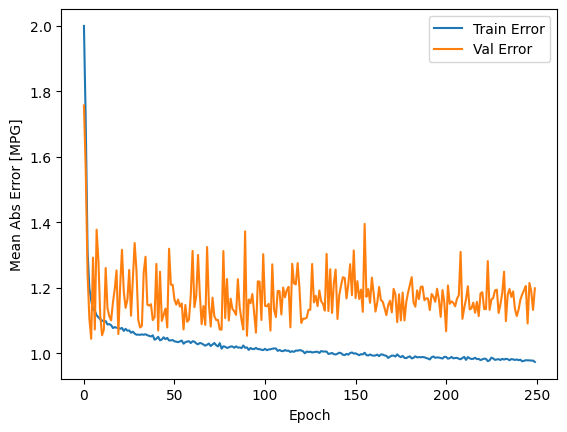

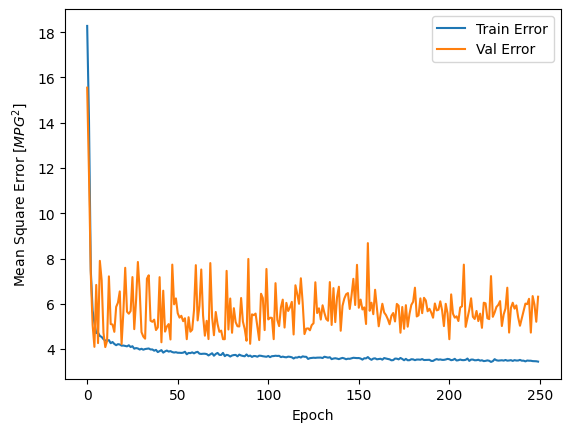

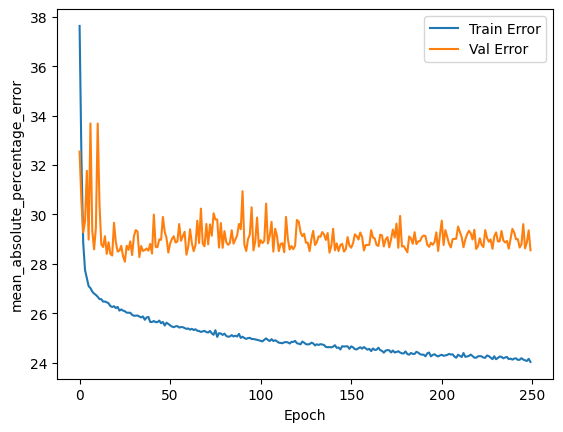

In [101]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('mean_absolute_percentage_error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [38]:
from sklearn.metrics import mean_absolute_percentage_error,median_absolute_error
mae_train = median_absolute_error(
        Y_train,
        Y_train_pred,
    ).round(2)

mae_test = median_absolute_error(
        Y_test,
        Y_test_pred,
    ).round(2)

In [39]:
print("entrenamiento:",mae_train,"validacion:",mae_test)

entrenamiento: 0.22 validacion: 0.2


In [40]:
from sklearn.metrics import mean_absolute_percentage_error,median_absolute_error
mape_train = mean_absolute_percentage_error(
        Y_train,
        Y_train_pred,
    ).round(2)

mape_test = mean_absolute_percentage_error(
        Y_test,
        Y_test_pred,
    ).round(2)

In [41]:
print("entrenamiento:",mape_train,"validacion:",mape_test)

entrenamiento: 0.25 validacion: 0.3


In [106]:
resultTest=pd.DataFrame()
resultTest["esperado"]=Y_train
resultTest["predicho"]=Y_train_pred

In [107]:
resultTest.sample(10)

,esperado,predicho
42555,2,1.000639
56481,1,1.000639
9845,2,1.000639
17962,1,1.000639
4022,1,1.000639
53305,3,1.000639
41188,1,1.000639
26042,2,1.982817
40751,2,1.878404
5895,8,4.877534


In [48]:
from tensorflow.keras.models import load_model
#t=mounths
#250
#entrenamiento: 0.19 validacion: 0.15
#model.save('modelo-V3.h5')
#500
#entrenamiento: 0.17 validacion: 0.18
#model.save('modelo-V3_1.h5')
model=load_model('modelo-V3_1.h5')

In [44]:
X_train.columns

Index(['t', 'CLASE_ACCIDENTE_caida ocupante', 'CLASE_ACCIDENTE_choque',
       'CLASE_ACCIDENTE_incendio', 'CLASE_ACCIDENTE_otro',
       'CLASE_ACCIDENTE_volcamiento', 'NUMCOMUNA_10', 'NUMCOMUNA_11',
       'NUMCOMUNA_12', 'NUMCOMUNA_13', 'NUMCOMUNA_14', 'NUMCOMUNA_15',
       'NUMCOMUNA_16', 'NUMCOMUNA_2', 'NUMCOMUNA_3', 'NUMCOMUNA_4',
       'NUMCOMUNA_5', 'NUMCOMUNA_6', 'NUMCOMUNA_7', 'NUMCOMUNA_8',
       'NUMCOMUNA_9', 'DIA_FESTIVO_True', 'DIA_DE_LA_SEMANA_1',
       'DIA_DE_LA_SEMANA_2', 'DIA_DE_LA_SEMANA_3', 'DIA_DE_LA_SEMANA_4',
       'DIA_DE_LA_SEMANA_5', 'DIA_DE_LA_SEMANA_6', 'MES_10', 'MES_11',
       'MES_12', 'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8',
       'MES_9', 'DIA_DEL_MES_10', 'DIA_DEL_MES_11', 'DIA_DEL_MES_12',
       'DIA_DEL_MES_13', 'DIA_DEL_MES_14', 'DIA_DEL_MES_15', 'DIA_DEL_MES_16',
       'DIA_DEL_MES_17', 'DIA_DEL_MES_18', 'DIA_DEL_MES_19', 'DIA_DEL_MES_2',
       'DIA_DEL_MES_20', 'DIA_DEL_MES_21', 'DIA_DEL_MES_22', 'DIA_DEL_MES_23',